# What's Cooking ??
## Predicting cuisine by analysing ingredients 
#### By Sanjeev Singh, Akanksha Jain, Vimal Deep Reddy

In [17]:
# Importing required libraries

from pandas import Series, DataFrame
import pandas as pd
import numpy as np
import nltk
import re
from nltk.stem import WordNetLemmatizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
import sklearn.metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import grid_search
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import random
import gc
import gensim
from pandas.plotting import _converter
import seaborn as sns
from gensim.models import word2vec

# Modelling Helpers, see above the description
from sklearn.manifold import TSNE

# Visualisation
import matplotlib.patches as mpatches
import seaborn as sns
%matplotlib inline
from __future__ import print_function
import json
import operator
import collections
from sklearn.feature_extraction.text import TfidfTransformer
from pylab import *
from scipy import *
import json
import collections
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer

### Getting the Train and Test Data

What's Cooking dataset provided by Yummly. The dataset has a list of ingredients and cuisines. The objective of the project is to predict the cuisine given the ingredients. We have used text mining vectorizating and then did classificatino using Randon Forest classifer and SGD Classifer.

Used WordNetLemmatizer to create a string of all ingredients for train and test data

In [32]:
traindf = pd.read_json("project3/train.json")


In [33]:
testdf = pd.read_json("project3/test.json") 


# Data Exploration
 

In [4]:
traindf.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


Using Raw json data as list to do quick exploration 

In [5]:
data= json.load(open('project3/train.json','r'))

#### Creating lists of ingredients and cusines

In [6]:
raw_ingredients = list()

for recipt in data:
    for ingredient in recipt[u'ingredients']:
        raw_ingredients.append(ingredient.strip())
        

raw_cuisines = list()
for recipt in data:
    raw_cuisines.append(recipt[u'cuisine'].strip())

counting number of igredients and cuisines

In [7]:
counts_ingr = collections.Counter(raw_ingredients)
counts_cuis = collections.Counter(raw_cuisines)

In [8]:
print('Size Ingredients dataset (with repetition):  \t{}'.format((len(raw_ingredients))))
print('Unique Ingredients dataset: \t\t\t{}'.format((len(counts_ingr.values()))))

# This will provide a distribution of cusines, indirect 
# info of the ingredients
print('Total # of recipts \t\t\t\t{}'.format(len(raw_cuisines)))
print('Total # of Cuisines \t\t\t\t{}'.format((len(counts_cuis.values()))))

Size Ingredients dataset (with repetition):  	428275
Unique Ingredients dataset: 			6714
Total # of recipts 				39774
Total # of Cuisines 				20


In [9]:
counts_cuis.most_common(10)

[('italian', 7838),
 ('mexican', 6438),
 ('southern_us', 4320),
 ('indian', 3003),
 ('chinese', 2673),
 ('french', 2646),
 ('cajun_creole', 1546),
 ('thai', 1539),
 ('japanese', 1423),
 ('greek', 1175)]

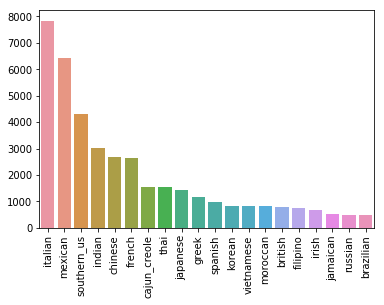

In [10]:
x_cu = [cu for cu, frq in counts_cuis.most_common()]
y_frq = [frq for cu, frq in counts_cuis.most_common()]
fbar = sns.barplot(x = x_cu, y = y_frq)
# xlabels
for item in fbar.get_xticklabels():
    item.set_rotation(90)

In [21]:
counts_ingr.most_common(15)

[('salt', 18049),
 ('onions', 7972),
 ('olive oil', 7972),
 ('water', 7457),
 ('garlic', 7380),
 ('sugar', 6434),
 ('garlic cloves', 6237),
 ('butter', 4848),
 ('ground black pepper', 4785),
 ('all-purpose flour', 4632),
 ('pepper', 4438),
 ('vegetable oil', 4385),
 ('eggs', 3388),
 ('soy sauce', 3296),
 ('kosher salt', 3113)]

In [22]:
# Tail 20
counts_ingr.most_common()[-20:]

[('whole wheat peasant bread', 1),
 ('ranch-style seasoning', 1),
 ('ketjap', 1),
 ('chocolate flavored liqueur', 1),
 ('rotini pasta, cook and drain', 1),
 ('game', 1),
 ('tongue', 1),
 ('Daiya', 1),
 ('curry mix', 1),
 ('Kraft Slim Cut Mozzarella Cheese Slices', 1),
 ('Oscar Mayer Cotto Salami', 1),
 ('Challenge Butter', 1),
 ('orange glaze', 1),
 ('cholesterol free egg substitute', 1),
 ('ciabatta loaf', 1),
 ('Lipton® Iced Tea Brew Family Size Tea Bags', 1),
 ('Hidden Valley® Greek Yogurt Original Ranch® Dip Mix', 1),
 ('lop chong', 1),
 ('tomato garlic pasta sauce', 1),
 ('crushed cheese crackers', 1)]

In [23]:
#Cleaning the data for vectorization

In [37]:
traindf['ingredients_clean_string'] = [' , '.join(z).strip() for z in traindf['ingredients']]  
traindf['ingredients_string'] = [' '.join([WordNetLemmatizer().lemmatize(re.sub('[^A-Za-z]', ' ', line)) for line in lists]).strip() for lists in traindf['ingredients']]       


In [38]:
testdf['ingredients_clean_string'] = [' , '.join(z).strip() for z in testdf['ingredients']]
testdf['ingredients_string'] = [' '.join([WordNetLemmatizer().lemmatize(re.sub('[^A-Za-z]', ' ', line)) for line in lists]).strip() for lists in testdf['ingredients']]       

## Vectorizing ingredients by using Tfidf Vectorizer

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english')

In [27]:
# Apply Term Frequency Inverse Document Frequency normalization to a sparse matrix of occurrence counts.
tfidf_matrix = vectorizer.fit_transform(traindf['ingredients_string']).todense()

In [28]:
# Created a dataframe with only one column: Cuisine
cuisines = traindf['cuisine']
cuisines.head()

0          greek
1    southern_us
2       filipino
3         indian
4         indian
Name: cuisine, dtype: object

### The chalnge is to classify the recepies based on ingedients used, we are using clasiification models to ientify the cuisines 

# Classification

Used two classifiers to classify the ingredients to a cuisine in the testdf 
- Random Forest Classifier
- SGD Classifier

**Random Forest Classifier**
- Uses huge collection of de-correlated decision trees
- Training data forms a matrix as input. The large number of new matrices with random elements are created
- Each of this matrices are used to form decision trees used for classification testing data

In [67]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(tfidf_matrix, cuisines)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [68]:
test_tfidf_matrix = vectorizer.transform(testdf['ingredients_string'])

In [69]:
# predicting the cuisines in the test dataset
test_cuisines = clf.predict(test_tfidf_matrix)

In [70]:
testdf['cuisine'] = test_cuisines
testdf.head()

,id,ingredients,ingredients_clean_string,ingredients_string,cuisine
0,18009,"[baking powder, eggs, all-purpose flour, raisi...","baking powder , eggs , all-purpose flour , rai...",baking powder egg all purpose flour raisin mil...,irish
1,28583,"[sugar, egg yolks, corn starch, cream of tarta...","sugar , egg yolks , corn starch , cream of tar...",sugar egg yolks corn starch cream of tartar ba...,southern_us
2,41580,"[sausage links, fennel bulb, fronds, olive oil...","sausage links , fennel bulb , fronds , olive o...",sausage links fennel bulb frond olive oil cuba...,italian
3,29752,"[meat cuts, file powder, smoked sausage, okra,...","meat cuts , file powder , smoked sausage , okr...",meat cuts file powder smoked sausage okra shri...,cajun_creole
4,35687,"[ground black pepper, salt, sausage casings, l...","ground black pepper , salt , sausage casings ,...",ground black pepper salt sausage casings leek ...,italian


In [71]:
from sklearn.model_selection import cross_val_score
cross_val_score(clf, tfidf_matrix , cuisines, cv=5, scoring="accuracy")

array([0.68726451, 0.70608193, 0.68677728, 0.68985033, 0.70315842])

Random Forest Classifier has a 69% accuracy.

In [ ]:


param_grid = [{'max_features': ['sqrt', 'log2']}]

forest_clf = RandomForestClassifier()
grid_search_forest = GridSearchCV(forest_clf, param_grid, cv=5, verbose=3)
grid_search_forest.fit(bike_prepared, bike_labels)

Fine tuning random forest classifier

In [ ]:
grid_search_forest.best_params_

In [75]:
grid_search_forest.best_score_

0.6953286066274451

Not much improvemnt

**SGD Classifier**

In [80]:
from sklearn.linear_model import SGDClassifier

In [81]:
#sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf = SGDClassifier(random_state=42)

In [82]:
sgd_clf.fit(tfidf_matrix, cuisines)

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [84]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, tfidf_matrix , cuisines, cv=5, scoring="accuracy")

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/site-packages/s

array([0.77153981, 0.77770797, 0.76809955, 0.77072066, 0.77941362])

SGD had a better accuracy of 77% compared to Random Forest Classifier

Fine tuning SGD classifier

In [93]:
param_grid= {
    'loss': ['log'],
    'penalty': ['elasticnet'],
    #'alpha': [10 ** x for x in range(-6, 1)],
    #'l1_ratio': [0, 0.05, 0.5, 1],
}
# selecting only 2 parameters, with all parameters it takes forever to run
grid_search_sgd = GridSearchCV(sgd_clf, param_grid, cv=5, verbose=3)
grid_search_sgd.fit(tfidf_matrix, cuisines)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] loss=log, penalty=elasticnet ....................................


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  loss=log, penalty=elasticnet, score=0.7378799296659131, total=  54.5s
[CV] loss=log, penalty=elasticnet ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   54.8s remaining:    0.0s
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  loss=log, penalty=elasticnet, score=0.7509424478512189, total=  54.4s
[CV] loss=log, penalty=elasticnet ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.8min remaining:    0.0s
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  loss=log, penalty=elasticnet, score=0.7405731523378583, total=  54.5s
[CV] loss=log, penalty=elasticnet ....................................


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  loss=log, penalty=elasticnet, score=0.7485850836372784, total=  55.5s
[CV] loss=log, penalty=elasticnet ....................................


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[CV]  loss=log, penalty=elasticnet, score=0.7493393733484334, total=  53.8s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.6min finished
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


GridSearchCV(cv=5, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'loss': ['log'], 'penalty': ['elasticnet']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [94]:
grid_search_sgd.best_params_

{'loss': 'log', 'penalty': 'elasticnet'}

In [95]:
grid_search_sgd.best_score_

0.7454618595062101

its going down?

## Word to vec
##### We are using google vector and local vectors both to compare

In [39]:
symbols = list()

for recipt in trainrecipts:

    # I want ingredient remove 
    for ingredient in recipt['ingredients']:
        if re.match("\(|@|\$\?", ingredient.lower()):
            symbols.append(ingredient)
len(symbols)
counts_symbols = collections.Counter(symbols)
counts_symbols.most_common(20)

[('(    oz.) tomato sauce', 11),
 ('(   oz.) tomato paste', 9),
 ('(14.5 oz.) diced tomatoes', 3),
 ('(15 oz.) refried beans', 3),
 ('(10 oz.) frozen chopped spinach', 3),
 ('(10 oz.) frozen chopped spinach, thawed and squeezed dry', 2),
 ('(14 oz.) sweetened condensed milk', 2)]

In [45]:
sentences = list()
# one hot ingredients

for recipt in trainrecipts:
    clean_recipt = list()
    # I want ingredient remove 
    for ingredient in recipt['ingredients']:
        # remove this description from the ingredients
        # minimal preprocessing
        ingredient =  re.sub(r'\(.*oz.\)|crushed|crumbles|ground|minced|powder|chopped|sliced',
                             '', 
                             ingredient)
        clean_recipt.append(ingredient.strip())
    sentences.append(clean_recipt)
        
len(sentences)

39774

In [46]:
# Set values for NN parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 3    # 50% of the corpus                    
num_workers = 4       # Number of CPUs
context = 10          # Context window size; 
                      # let's use avg recipte size                                                                                  
downsampling = 1e-3   # threshold for configuring which 
                    # higher-frequency words are randomly downsampled

# Initialize and train the model 
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)  

# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
model.init_sims(replace=True)

In [42]:
model1=word2vec.Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

In [43]:

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

model1.wv.most_similar(u'feta cheese')
model.most_similar(u'feta')



[('feta_cheese', 0.7989499568939209),
 ('parmesan', 0.6892859935760498),
 ('goat_cheese', 0.689011812210083),
 ('tzatziki', 0.6815816760063171),
 ('Feta_cheese', 0.6772351861000061),
 ('haloumi', 0.6740899085998535),
 ('ricotta', 0.6651490926742554),
 ('Parmesan', 0.6648129820823669),
 ('fontina', 0.6606416702270508),
 ('pecorino', 0.6598587036132812)]

In [44]:
model1.wv.similarity('broccoli', 'bacon')
model.similarity('broccoli', 'bacon')

0.3247047877938627

0.4854979864225662

In [45]:
model1.wv.similarity('broccoli', 'carrots')
model.similarity('broccoli', 'carrots')

0.6525828703078209

0.644994201800512

In [46]:
model1.wv.similarity('broccoli', 'mushrooms')
model.similarity('broccoli', 'mushrooms')

0.830366553392748

0.6128388113766572

In [47]:


#['garlic', 'onion'], ['olive oil']
x = 'basil'
b= 'ketchup'
a = 'pasta'
predicted = model1.wv.most_similar([x, b], [a])[0][0]
print(" {} is to  {} as {} is to {} ".format(a, b, x, predicted))

predicted = model.most_similar([x, b], [a])[0][0]
print(" {} is to  {} as {} is to {} ".format(a, b, x, predicted))
# pasta is to  tomato sauce as basil is to fresh tomatoes 

 pasta is to  ketchup as basil is to sauce 
 pasta is to  ketchup as basil is to oregano 


In [48]:


#['garlic', 'onion'], ['olive oil']
x = 'chicken'
b= 'broccoli'
a = 'bacon'
predicted = model1.wv.most_similar([x, b], [a])[0][0]
print(" {} is to  {} as {} is to {} ".format(a, b, x, predicted))

predicted = model.most_similar([x, b], [a])[0][0]
print(" {} is to  {} as {} is to {} ".format(a, b, x, predicted))
#bacon is to  broccoli as chicken is to chili pepper 

 bacon is to  broccoli as chicken is to firm tofu 
 bacon is to  broccoli as chicken is to vegetables 


In [49]:
# Similarity between two ingredients in both models
model1.wv.most_similar_cosmul(positive=['dough', u'water'], negative=['milk'])
model.most_similar_cosmul(positive=['pasta', u'vegetables'], negative=['meat'])
#[('tamarind paste', 1.275578260421753),
# ('canned coconut milk', 1.2714498043060303),
 #('coconut oil', 1.2700440883636475),
 #('pork shoulder', 1.250213384628296),
 #('cilantro leaves', 1.2499377727508545),
 #('chiles', 1.2483551502227783),
 #('cilantro', 1.2317484617233276),
 #('lime', 1.2305859327316284),
 #('tamarind pulp', 1.227728009223938),
 #('coconut cream', 1.2249802350997925)]

[('peeled fresh ginger', 1.2616881132125854),
 ('less sodium soy sauce', 1.203568696975708),
 ('salmon fillets', 1.1830406188964844),
 ('dry roasted peanuts', 1.1698369979858398),
 ('yellow miso', 1.168859601020813),
 ('thai green curry paste', 1.1657953262329102),
 ('gingerroot', 1.1652518510818481),
 ('sea bass fillets', 1.1575528383255005),
 ('unsweetened coconut milk', 1.1502810716629028),
 ('reduced fat coconut milk', 1.139535665512085)]

[('veggies', 0.9838905930519104),
 ('fresh_herbs', 0.9384022951126099),
 ('pastas', 0.9356766939163208),
 ('tomato_sauce', 0.9262071251869202),
 ('cauliflower', 0.9244133234024048),
 ('salads', 0.9183255434036255),
 ('zucchini', 0.9129700660705566),
 ('tomatoes_peppers', 0.9124463200569153),
 ('basil', 0.911659836769104),
 ('swiss_chard', 0.91140216588974)]

In most of the cases local vector is better than google 

### here we are trying to use Kmeans clustering and plotting the same  most of the code is from 
https://www.kaggle.com/alonalevy/cultural-diffusion-by-recipes?scriptVersionId=488411, with little modification

In [76]:
 data = json.load(open('project3/train.json'))

In [83]:
def create_dict_cuisine_ingred(json):
    dictCuisineIngred = {}
    cuisines = []
    ingredients = []
    
    for i in range(len(json)):
        
        # just changing the name of one of the cuisines so
        # it is more readable in the final visualization
        cuisine = json[i]['cuisine']
        if cuisine == 'southern_us':
            cuisine = 'southUS'

        ingredientsPerCuisine = json[i]['ingredients']
        
        if cuisine not in dictCuisineIngred.keys():
            cuisines.append(cuisine)
            dictCuisineIngred[cuisine] = ingredientsPerCuisine
            
        else: 
            currentList = dictCuisineIngred[cuisine]
            currentList.extend(ingredientsPerCuisine)
            dictCuisineIngred[cuisine] = currentList
                 
        ingredients.extend(ingredientsPerCuisine)
         
    ingredients = list(set(ingredients)) # unique list of ALL ingredients
    numUniqueIngredients = len(ingredients)
    numCuisines = len(cuisines)
    
    return dictCuisineIngred, numCuisines, numUniqueIngredients, cuisines, ingredients


In [84]:
def create_term_count_matrix(dictionary, numCuisines, numIngred, cuisines, ingredients):
    termCountMatrix = np.zeros((numCuisines,numIngred))
    i = 0
    
    for cuisine in cuisines:
        ingredientsPerCuisine = dictCuisineIngred[cuisine]

        for ingredient in ingredientsPerCuisine:
            j = ingredients.index(ingredient) #in order to know which column to put the term count in, we will ago according to the terms' order in the ingredients array
            termCountMatrix[i,j] += 1

        i += 1

    return termCountMatrix
    

dictCuisineIngred, numCuisines, numIngred, cuisines, ingredients = create_dict_cuisine_ingred(data)
countsMatrix = create_term_count_matrix(dictCuisineIngred, numCuisines, numIngred, cuisines, ingredients)

In [55]:
from scipy import sparse
from sklearn.decomposition import PCA
get_ipython().magic(u'matplotlib inline')


In [85]:
def tf_idf_from_count_matrix(countsMatrix):
    
    countsMatrix = sparse.csr_matrix(countsMatrix)
    transformer = TfidfTransformer()
    tfidf = transformer.fit_transform(countsMatrix) # normalizes vectors to mean 0 and std 1 and computes tf-idf
    tfidf.toarray() 
    return tfidf.toarray()

In [89]:
tfIdf_Matrix = tf_idf_from_count_matrix(countsMatrix)


In [90]:
pca = PCA(n_components=2)

In [92]:
reduced_data = pca.fit_transform(tfIdf_Matrix)

In [93]:
pca2dataFrame = pd.DataFrame(reduced_data)
pca2dataFrame.columns = ['PC1', 'PC2']

In [94]:


def kmeans_cultures(numOfClusters):
    
    kmeans = KMeans(init='k-means++', n_clusters=numOfClusters, n_init=10)
    kmeans.fit(reduced_data)
    return kmeans.predict(reduced_data)

labels = kmeans_cultures(5)

In [95]:
i = 0 
j = 0 

effect_on_cluster = [0 for cuisine in cuisines]

for cuisineA in cuisines:  

    A_intersection = 0
    numInClusterBesidesA = 0
    setA = set(dictCuisineIngred[cuisineA])
    setB_forA = []
    j = 0
    
    for cuisineB in cuisines:
        if cuisineB != cuisineA: # if it is A itself - we obviously wouldn't want this (will be exactly 1)
            if labels[j] == labels[i]: #determines if then they are both in the same cluster
                setB_forA.extend(set(dictCuisineIngred[cuisineB]))
                numInClusterBesidesA += 1
        j += 1
    
    A_intersection = len(set(setA & set(setB_forA))) / float(len(set(setA.union(setB_forA))))
    effect_on_cluster[i] = A_intersection
       
    i += 1

/Users/sanjeev/Documents/code/py3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


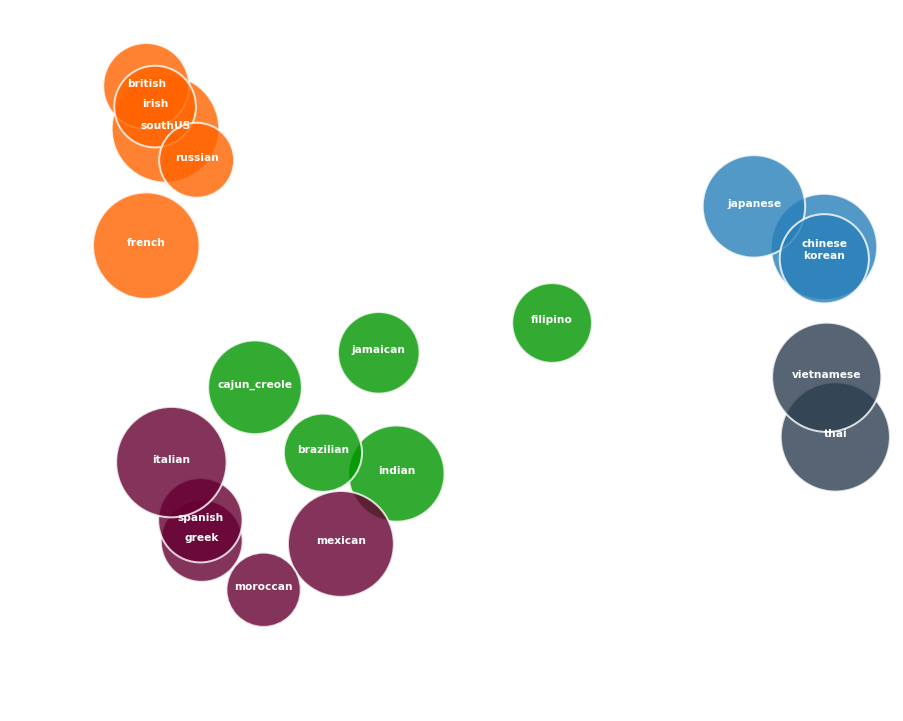

In [96]:

rdata = reduced_data
i=0
figureRatios = (15,20)
x = []
y = []
color = []
area = []

#creating a color palette:
colorPalette = ['#009600','#2980b9', '#ff6300','#2c3e50', '#660033'] 
# green,blue, orange, grey, purple

plt.figure(1, figsize=figureRatios)

for data in rdata:
    x.append(data[0]) 
    y.append(data[1])  
    color.append(colorPalette[labels[i]]) 
    area.append(effect_on_cluster[i]*27000) # magnifying the bubble's sizes (all by the same unit)
    # plotting the name of the cuisine:
    text(data[0], data[1], cuisines[i], size=10.6,horizontalalignment='center', fontweight = 'bold', color='w')
    i += 1

plt.scatter(x, y, c=color, s=area, linewidths=2, edgecolor='w', alpha=0.80) 

plt.axis([-0.45,0.65,-0.55,0.55])
plt.axes().set_aspect(0.8, 'box')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.axis('off') # removing the PC axes

plt.show()


The five color bubbles clusters show the cuisines that have similar ingredients. 
- We can see the black bubbles:  Chinese, Korean and Japanese cuisines have similar ingredients and are not seen in any other cuisine. 
- Vietnamese and Thai are closest to the black bubble clusters
- British, Irish, South US, Russia and French cuisine also consists of similar ingredients and are clustered together represented by the orange bubbles
- Spanish, Greek, Italian are closest in the blue bubbles cluster. Moroccan, Mexican, Brazilian and Cajun_creole are also in the blue bubble clusters but not overlapping which shows only few ingredients are similar in these cuisines.
- Lastly, the maroon bubbles are spread apart not formly a clear cluster and are closest to the blue bubbles. For these cuisines not all ingredients are the same but still there is enough similarity to be of the same color. 

## Word Cloud

In [96]:
#word cloud showing the most common ingredients
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=250,
        max_font_size=40, 
        scale=3,
        #random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=15)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

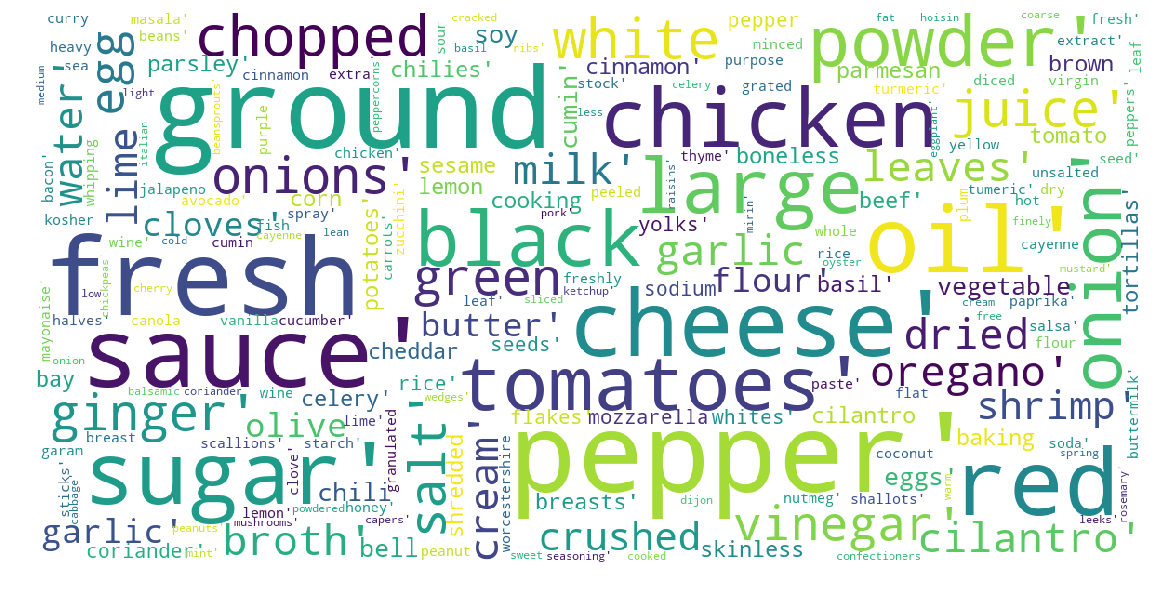

In [97]:
if __name__ == '__main__':
    show_wordcloud(counts_ingr.most_common(200))

# Bag of words

In [47]:

train_df = pd.read_json('project3/train.json')

In [66]:


import collections
bow = [ collections.Counter(recipe) for recipe in train_df.ingredients ]
sumbags = sum(bow, collections.Counter())




TypeError: 'Counter' object cannot be interpreted as an integer

In [21]:

fig = pd.DataFrame(sumbags, index=[0]).transpose()[0].sort_values(ascending=False, inplace=False)[:10].plot(kind='barh')
fig.invert_yaxis()
fig = fig.get_figure()
fig.tight_layout()
plt.show()

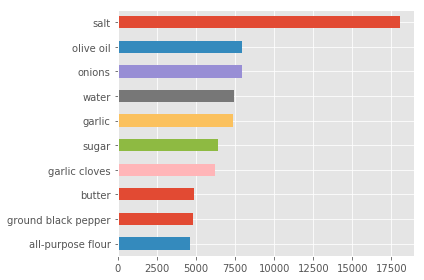

TypeError: expected string or bytes-like object

top 10 ingridients in Italian cusine

In [42]:
train_ind = traindf[traindf.cuisine == "indian"]

In [45]:

import collections, re
texts = train_ind['ingredients_clean_string']
bagsofwords = [ collections.Counter(re.findall(r'\w+', txt))
            for txt in texts]
bagsofwords[10]

Counter({'basmati': 1,
         'cauliflower': 1,
         'chilies': 1,
         'cilantro': 1,
         'coconut': 1,
         'coriander': 1,
         'cumin': 1,
         'fresh': 2,
         'garam': 1,
         'ginger': 1,
         'green': 1,
         'ground': 1,
         'masala': 1,
         'milk': 1,
         'oil': 1,
         'olive': 1,
         'onions': 1,
         'potatoes': 1,
         'rice': 1,
         'salt': 1,
         'scallions': 1,
         'sea': 1,
         'water': 1})